>In this notebook, we will build and train a deep learning model for binary classification of Apnea events.
In order to accomplish this, we will use training data [from PhysioNet 2018 Apnea/RERA challenge](https://physionet.org/physiobank/database/challenge/2018/). This public dataset contains 13 physiological signals, but we will use only 3 signals (electromyography from chest, and abdomen, plus oxygen saturation) disregarding electroencephalography and electrooculography signals. Therefore, we are limited to normal and apnea samples (Hypopnea, Central apnea, Mixed apnea and Obstructive apnea) and not able to classify RERA events. Cost of clinical trials can be reduced by utilising less equipment, which will still be sufficient to reproduce signals similar to the ones in public dataset. These 3 signals can be retrieved from a portable [Fingertip Pulse Oximeter](https://123checkup.com/product/wristband-pulse-oximeter-torontek-b400/) and [Hexoskin Smart Shirts](https://www.hexoskin.com/). It should be noted that Hexoskin can also provide ECG signals; however, from our experience ECG signal was very unstable, with signal loss and noise. This was probably due to weak contact with the body during the sleep.

# Content:
- [Import of libraries and functions](#Libraries)
- [Deep Learning Model](#Deep-Model)
- [Training of the model](#Training-Model)
- [Testing model](#Testing-Model)
- [Error Analysis](#Error-Analysis)

## Libraries

In [1]:
# Import of libraries for working with the data
from utils_apnea import *
%matplotlib inline
%load_ext watermark
%watermark

Using TensorFlow backend.


2019-04-08T01:35:58-04:00

CPython 3.6.8
IPython 6.4.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit


In [2]:
%watermark --iversions

wfdb       2.0.2
tensorflow 1.9.0
numpy      1.14.5
matplotlib 3.0.2
keras      2.2.0
pandas     0.23.1



In [3]:
!nvidia-smi

Mon Apr  8 01:36:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   27C    P5    38W / 275W |      0MiB / 11177MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

-------

## Deep Model

In [4]:
# Defining parameters
bufferSizeInSec = 60
samplingRateInHz = 200
newSamplingRateInHz = 100

> At this point any neural network can be used to train classification algorithm.  
> The model below is based on ResNet architecture, with the use of Keras `layers.SeparableConv1D` and `layers.CuDNNGRU`

In [5]:
X_input = keras.layers.Input(shape=(newSamplingRateInHz*bufferSizeInSec, len(channels)), name='X_input_ab')

X = layers.CuDNNGRU(512, return_sequences=True)(X_input)

# Stage 1
X = layers.Conv1D(256, 16, strides = 1, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.BatchNormalization(name = 'bn_conv1')(X)
X = layers.Activation('relu')(X)
X = layers.MaxPooling1D(16, strides = 2)(X)

# Stage 2
X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

# Stage 3 
X = convolutional_block(X, f = 3, filters = [128, 128, 128], stage = 3, block='a', s = 2)
X = identity_block(X, 3, [128, 128, 128], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 128], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 128], stage=3, block='d')

# Stage 4
X = convolutional_block(X, f = 3, filters = [256, 256, 256], stage = 4, block='a', s = 2)
X = identity_block(X, 3, [256, 256, 256], stage=4, block='b')
X = identity_block(X, 3, [256, 256, 256], stage=4, block='c')
X = identity_block(X, 3, [256, 256, 256], stage=4, block='d')
X = identity_block(X, 3, [256, 256, 256], stage=4, block='e')
X = identity_block(X, 3, [256, 256, 256], stage=4, block='f')

# Stage 5 
X = convolutional_block(X, f = 3, filters = [512, 512, 512], stage = 5, block='a', s = 2)
X = identity_block(X, 3, [512, 512, 512], stage=5, block='b')
X = identity_block(X, 3, [512, 512, 512], stage=5, block='c')

X = layers.Bidirectional(layers.CuDNNLSTM(128, return_sequences=True))(X)
X = layers.GlobalAveragePooling1D()(X)
X = (layers.Dense(64, activation='relu'))(X)

X = layers.Dense(32, activation='relu')(X)

X = layers.Dense(16, activation='relu')(X)

# output layer
y = layers.Dense(1,  activation='sigmoid')(X)
model  = Model(inputs = X_input, outputs = y)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input_ab (InputLayer)         (None, 6000, 3)      0                                            
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 6000, 512)    794112      X_input_ab[0][0]                 
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 5985, 256)    2097408     cu_dnngru_1[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 5985, 256)    1024        conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
# Let's plot model to pdf
plot_model(model, show_shapes=True, to_file='Model.pdf')

In [7]:
# Model compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

## Training Model

In [ ]:
# Defining path were trained model will be saved
saved_model_file = os.path.join(os.path.abspath("../models/"),'apnea_only_{}.h5'.format('binary_v2'))

# Saving best model
checkpoint = keras.callbacks.ModelCheckpoint(saved_model_file, monitor='val_loss', save_best_only=True, verbose=1)

# Saving logs
csv_logger = keras.callbacks.CSVLogger(os.path.join(os.path.abspath("../logs/"),'apnea_{}.csv'.format('binary_v2')), append=True, separator=',')

# Shuffling of input dataset and leaving 90 records for test set
ids = list(range(0,900))
np.random.shuffle(ids)

for steps in range(0,1000):
    Xt = np.empty((0,5))
    Xv = np.empty((0,5))
    
    # How many seconds to shift when generating new set
    strideInSec = 12 
    for combine in range(4):
        # random pick of train set record
        patient = np.random.choice(ids[:-250])
        
        # Change online to False if data is loaded from local drive
        trainData, numberOfChannels = generateDataPerPatient(patient, channels = channels, online = False)  
        
        # random pick of val set record
        valid = np.random.choice(ids[-250:])   
        validData, numberOfChannels = generateDataPerPatient(valid, channels = channels, online = False)
        Xt = np.append(Xt, trainData, axis=0)
        Xv = np.append(Xv, validData, axis=0)
        
        # train record id
        print('Patient: {}'.format(patient))
        # validation record id
        print('Validation: {}'.format(valid)) 
    for sampleShift in range(0,newSamplingRateInHz*bufferSizeInSec,newSamplingRateInHz*strideInSec):
        print('Shift #: {}'.format(sampleShift))
        xTrain, yTrain = generate_arrays_from_file_withoutBatch(Xt, numberOfChannels, sampleShift, bufferSizeInSec, samplingRateInHz, 
                                                                upsample = True, binary = True, newFreq = True, newSamplingRateInHz = newSamplingRateInHz)
        xVal, yVal   = generate_arrays_from_file_withoutBatch(Xv, numberOfChannels, sampleShift, bufferSizeInSec, samplingRateInHz, 
                                                                upsample = True, binary = True, newFreq = True, newSamplingRateInHz = newSamplingRateInHz)
        # training model 
        hist = model.fit(xTrain, yTrain, batch_size=32, validation_data=(xVal, yVal), 
                                   epochs=1, class_weight='auto', callbacks=[checkpoint, csv_logger])

-------

Once model is trained you can either reload complete model by `model = load_model('../models/apnea_only_binary_v2.h5')` by importing (`from keras.models import load_model`)

## Testing Model

In [8]:
model.load_weights('../models/apnea_only_binary_v2.h5')

In [9]:
# Some plotting parameters
rcParams['figure.figsize'] = 40, 6
%config InlineBackend.figure_format = 'retina'

In [10]:
# Combining several patients into test dataset

X = np.empty((0,6000,3))
Y = np.empty(0)
Y2 = np.empty((0,6000,2))
for id_test in range(963,980):
    testData, numberOfChannels = generateTestDataPerPatient(id_test, channels = channels, online = False)
    xTest, yTest, y2Test = generateBatch(testData, numberOfChannels, bufferSizeInSec, samplingRateInHz, 
                                                                newFreq = True, newSamplingRateInHz = newSamplingRateInHz)
    X = np.append(X, xTest, axis=0)
    Y = np.append(Y, yTest, axis=0)
    Y2 = np.append(Y2,y2Test, axis=0)

print(X.shape, Y.shape, Y2.shape)

(7712, 6000, 3) (7712,) (7712, 6000, 2)


In [11]:
# Making predictions
ypred = model.predict(X, verbose=1, batch_size=32)

7712/7712 [==============================] - 97s 13ms/step


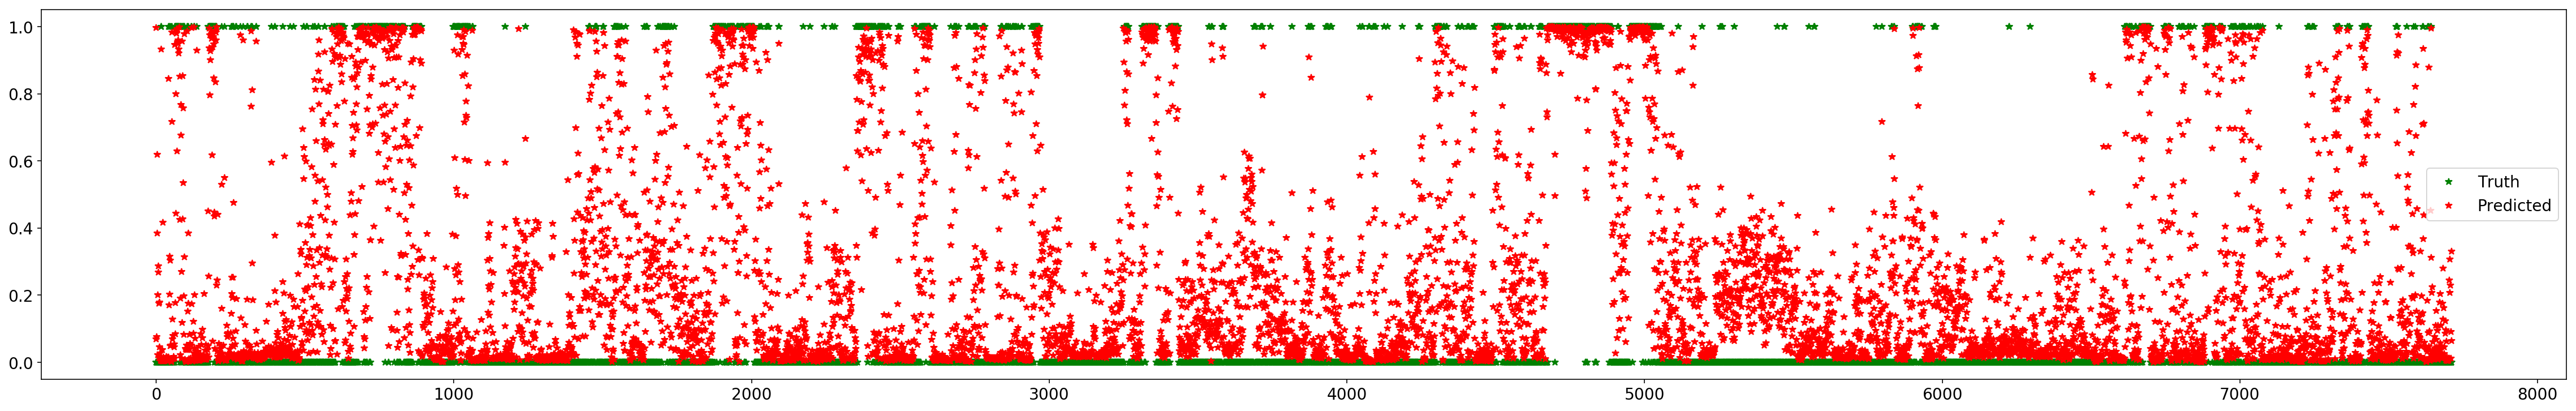

In [12]:
# Plotting predictions
rcParams['figure.figsize'] = 40, 6
plt.plot(Y, "*g", label='Truth');
plt.plot(ypred, '*r', label='Predicted');
plt.legend();

In [13]:
ypred[ypred>=0.5] = 1
ypred[ypred<0.5] = 0

# Error Analysis
!['Types of errors'](https://cdn-images-1.medium.com/max/2000/1*7EYylA6XlXSGBCF77j_rOA.png)

Confusion matrix, without normalization
[[5796  383]
 [ 380 1153]]


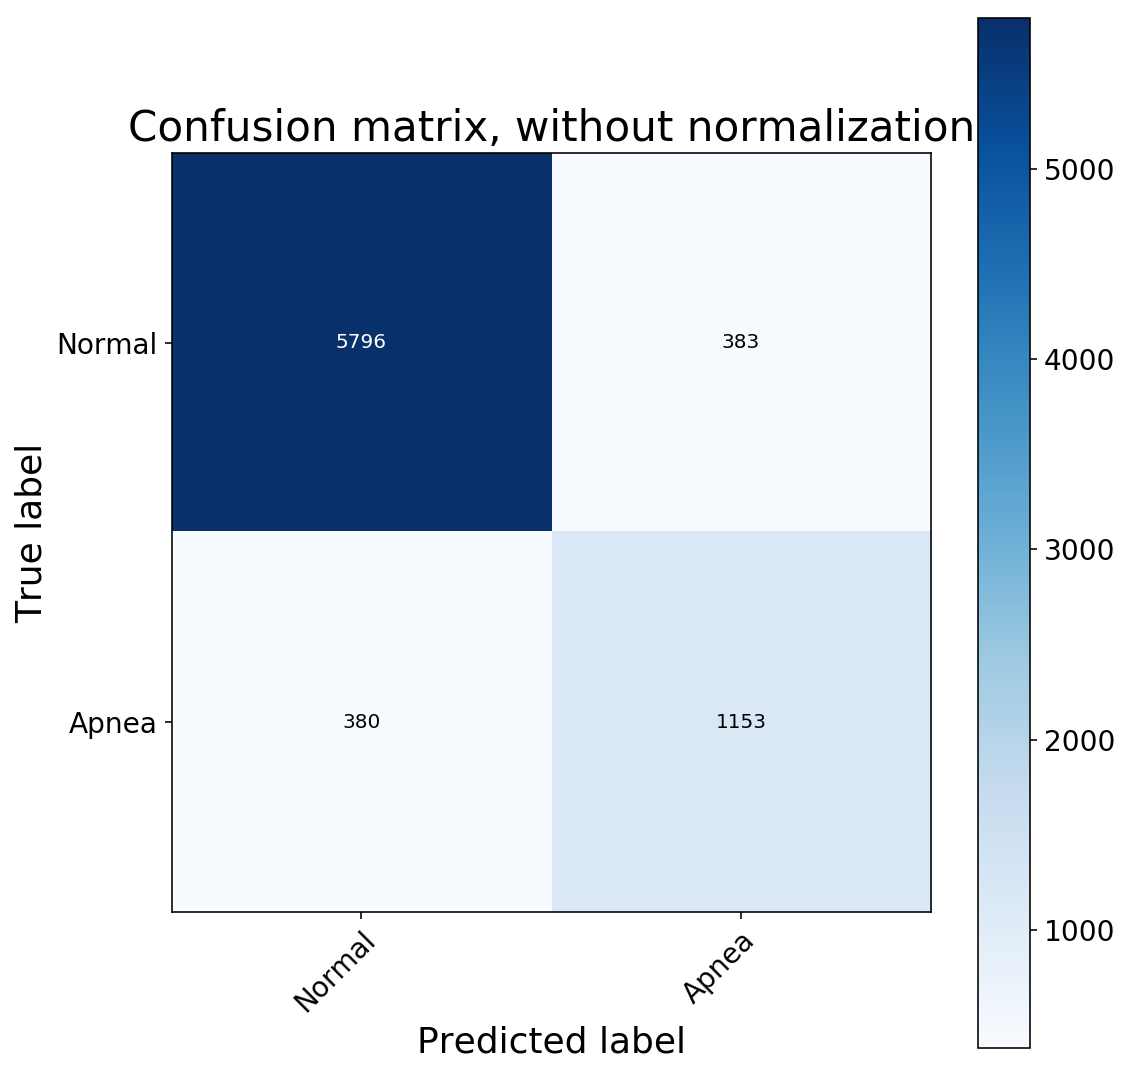

In [14]:
# Plotting confusion matrix
rcParams['figure.figsize'] = 8, 8
plot_confusion_matrix(Y, ypred.reshape(-1), classes=['Normal', 'Apnea'], title='Confusion matrix, without normalization');

Normalized confusion matrix
[[0.93801586 0.06198414]
 [0.24787997 0.75212003]]


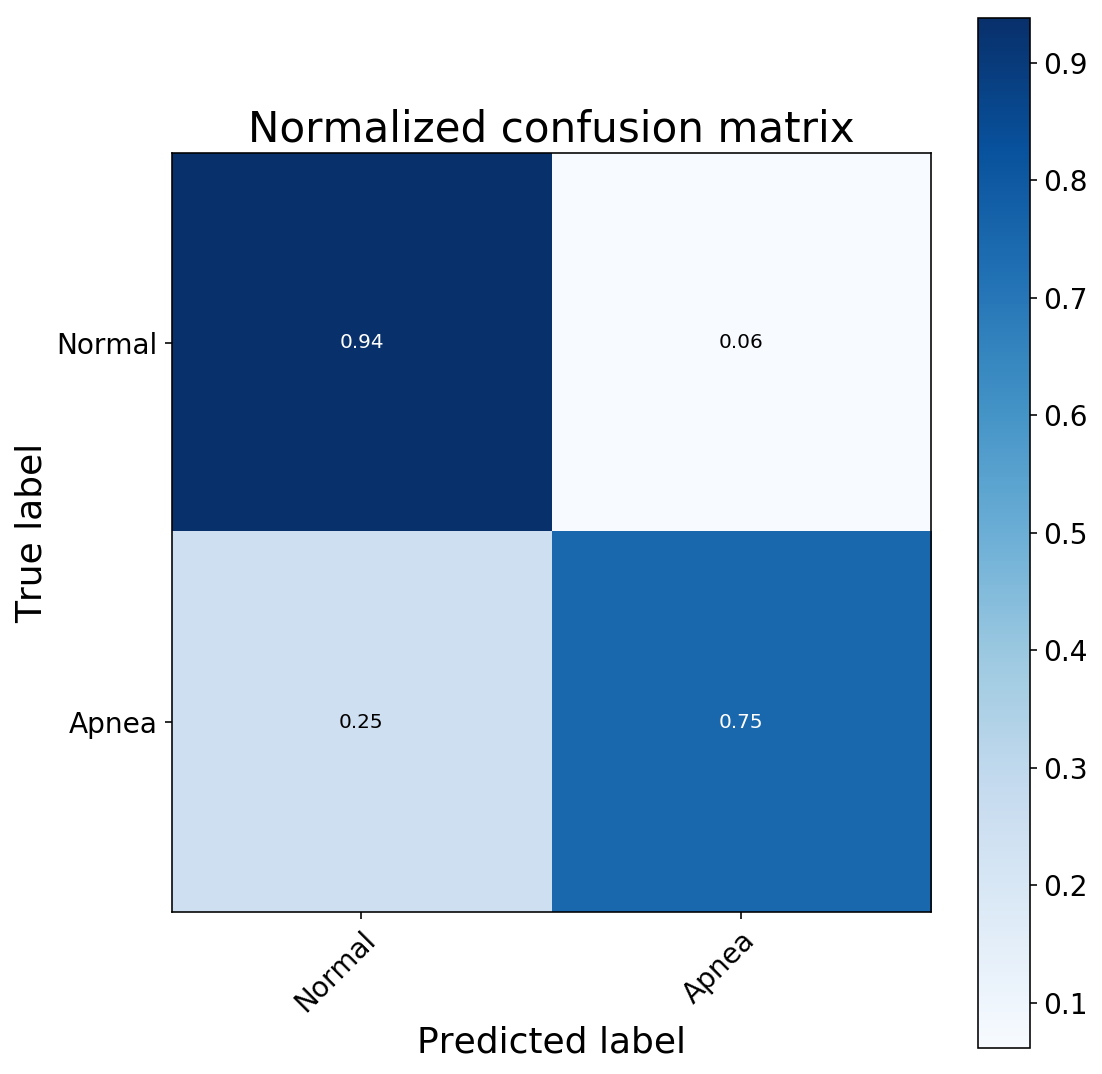

In [15]:
# Plot normalized confusion matrix
plot_confusion_matrix(Y, ypred.reshape(-1), classes=['Normal', 'Apnea'], normalize=True, title='Normalized confusion matrix');

In [16]:
# Let's plot some misclassified samples
indices = np.flatnonzero(Y != ypred.T)

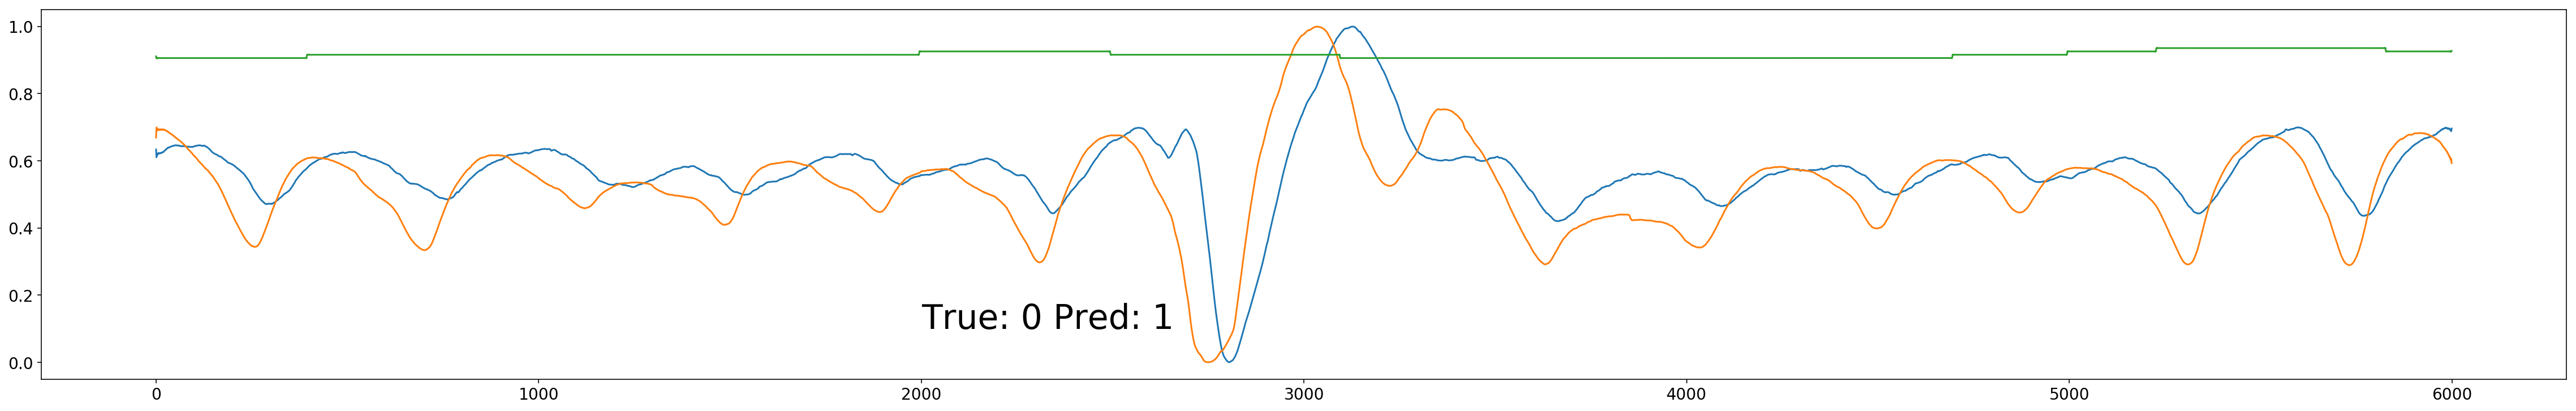

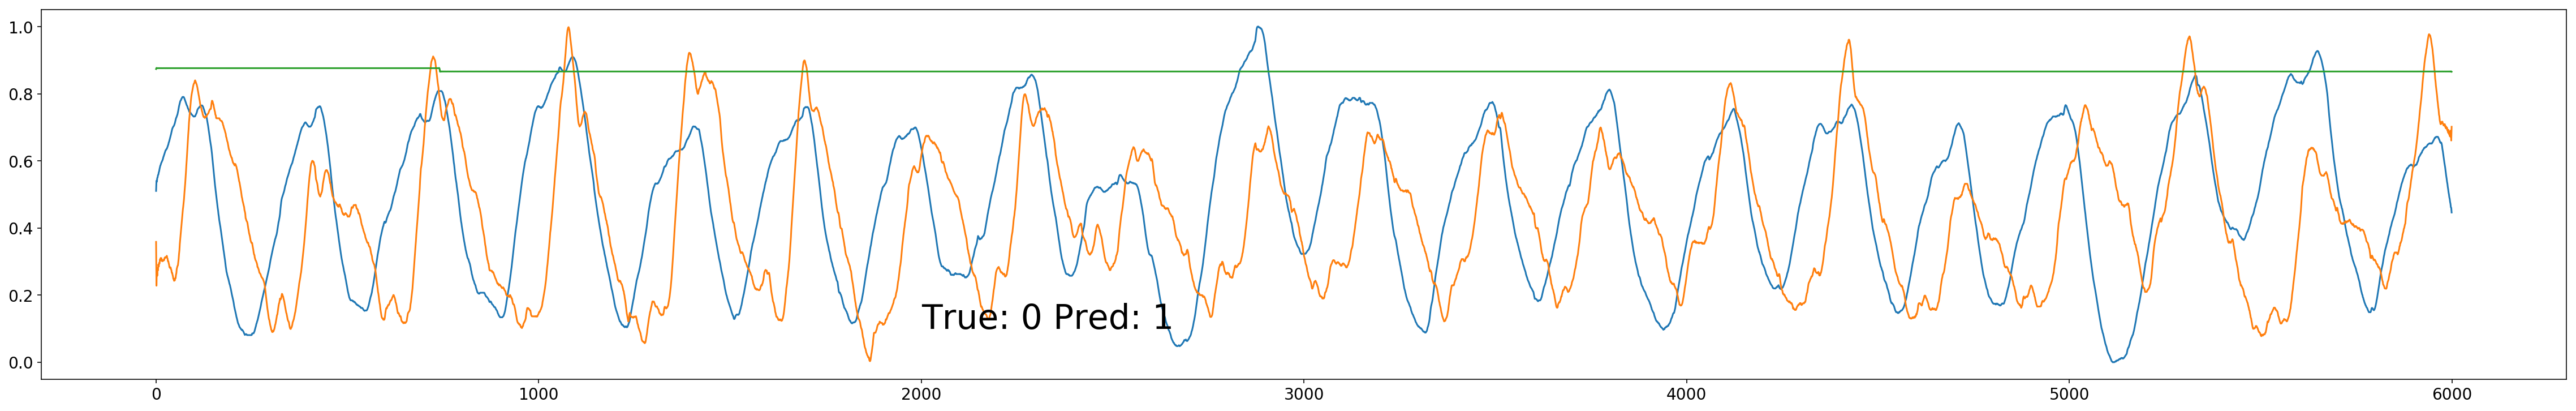

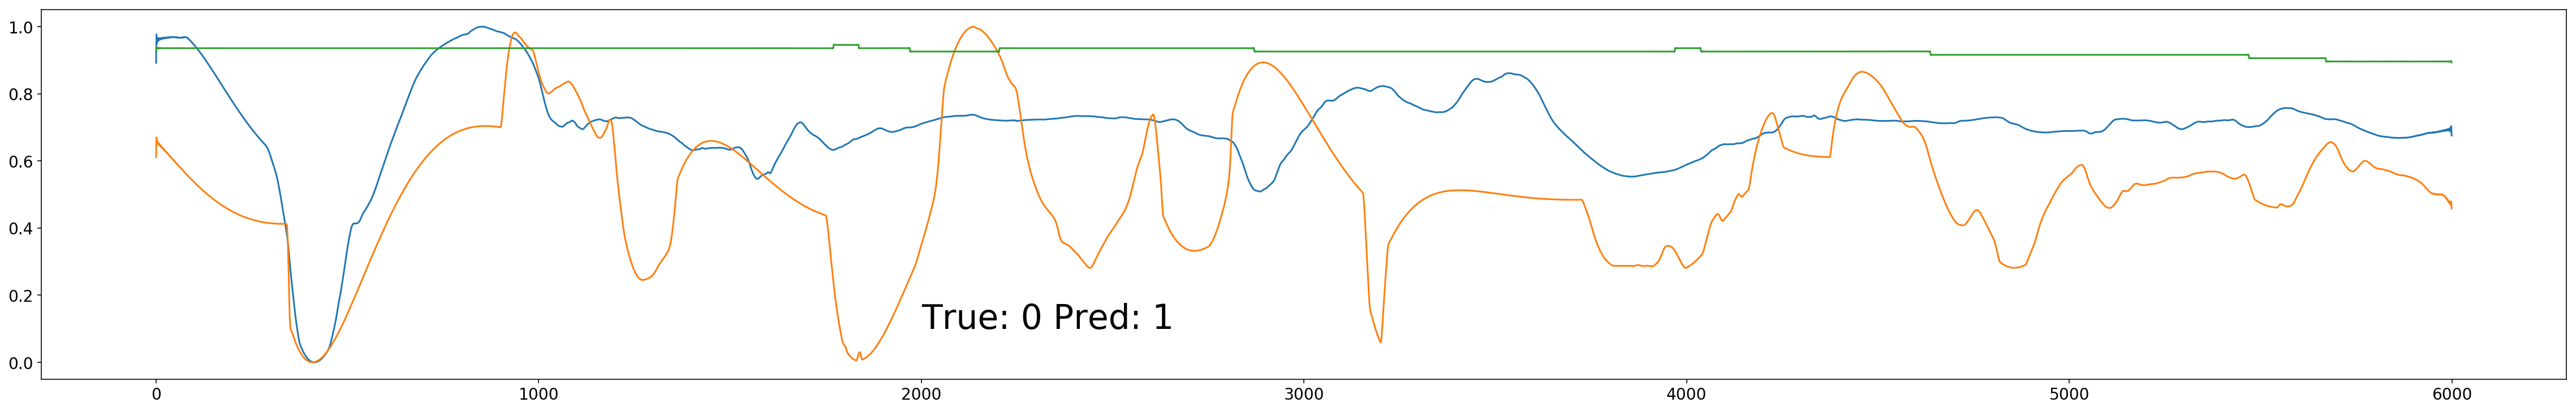

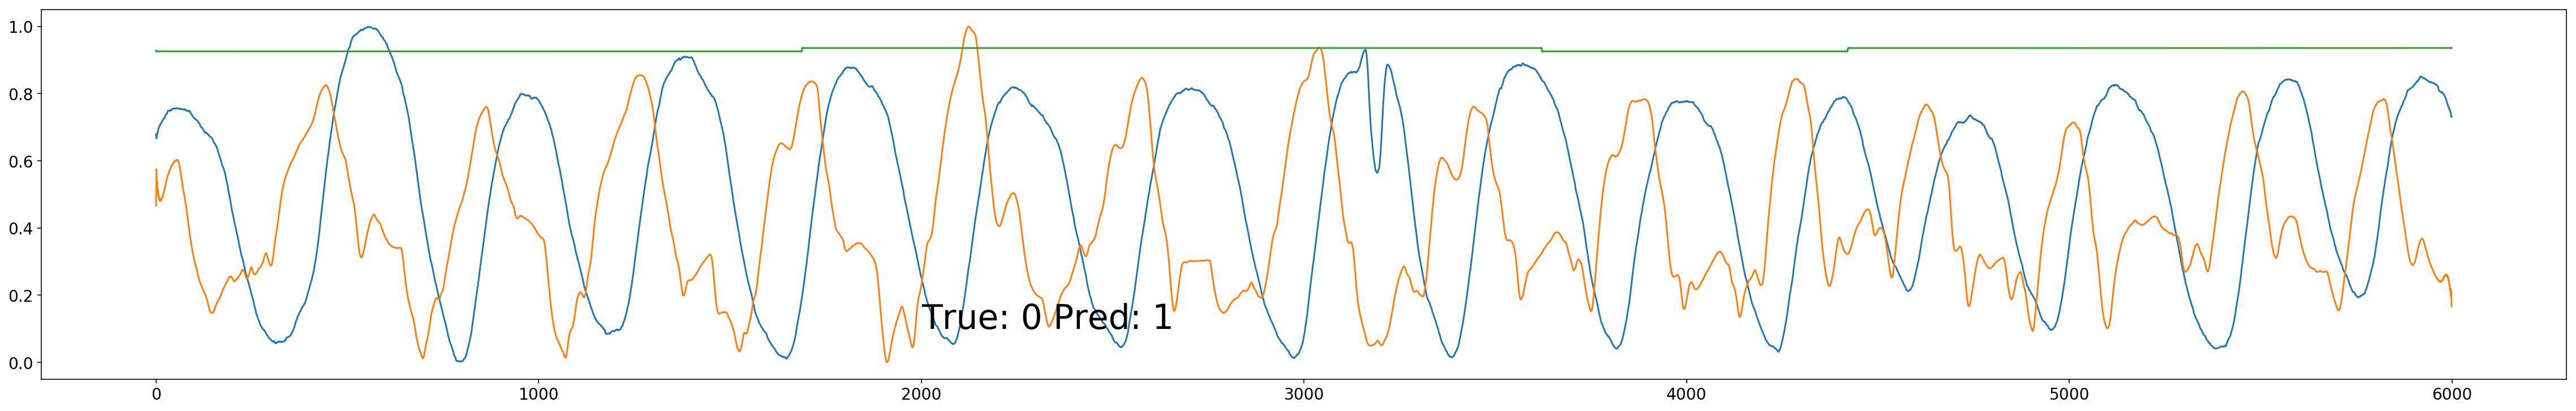

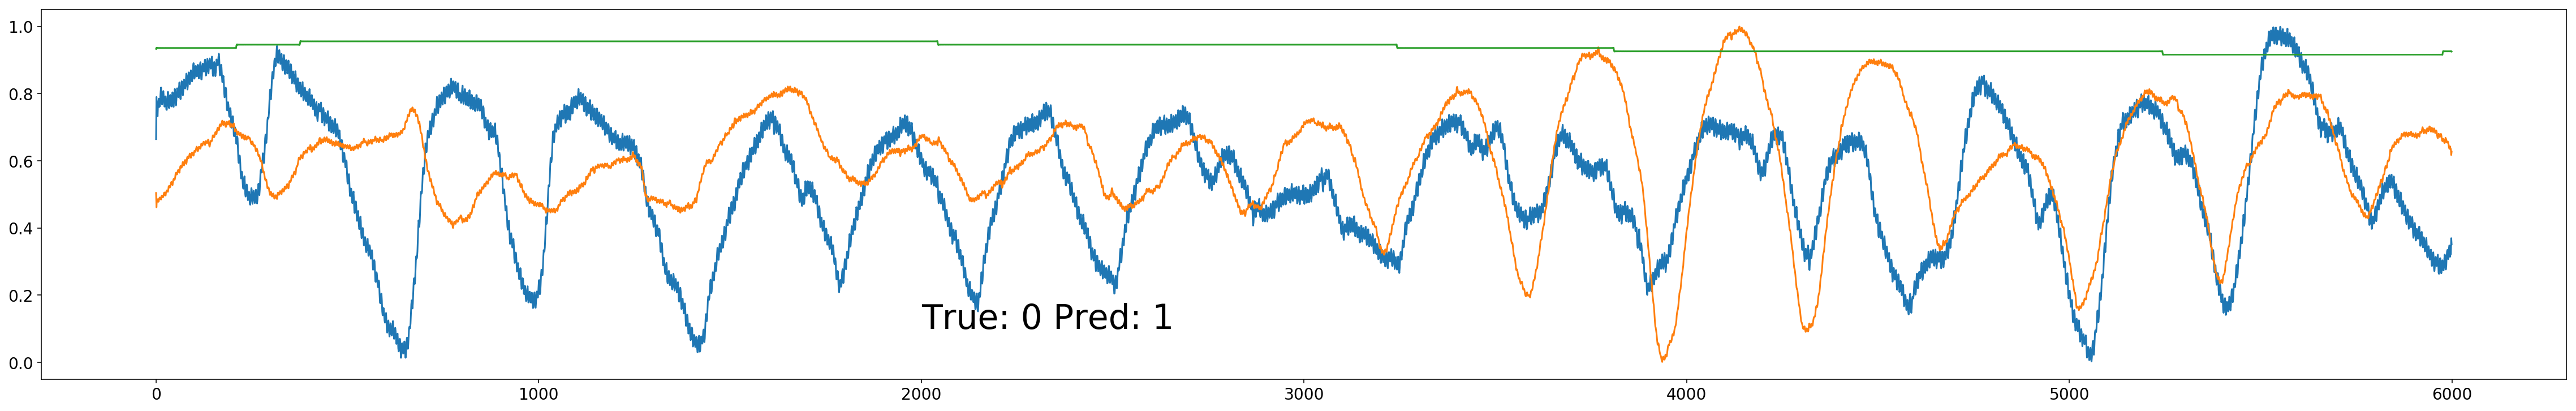

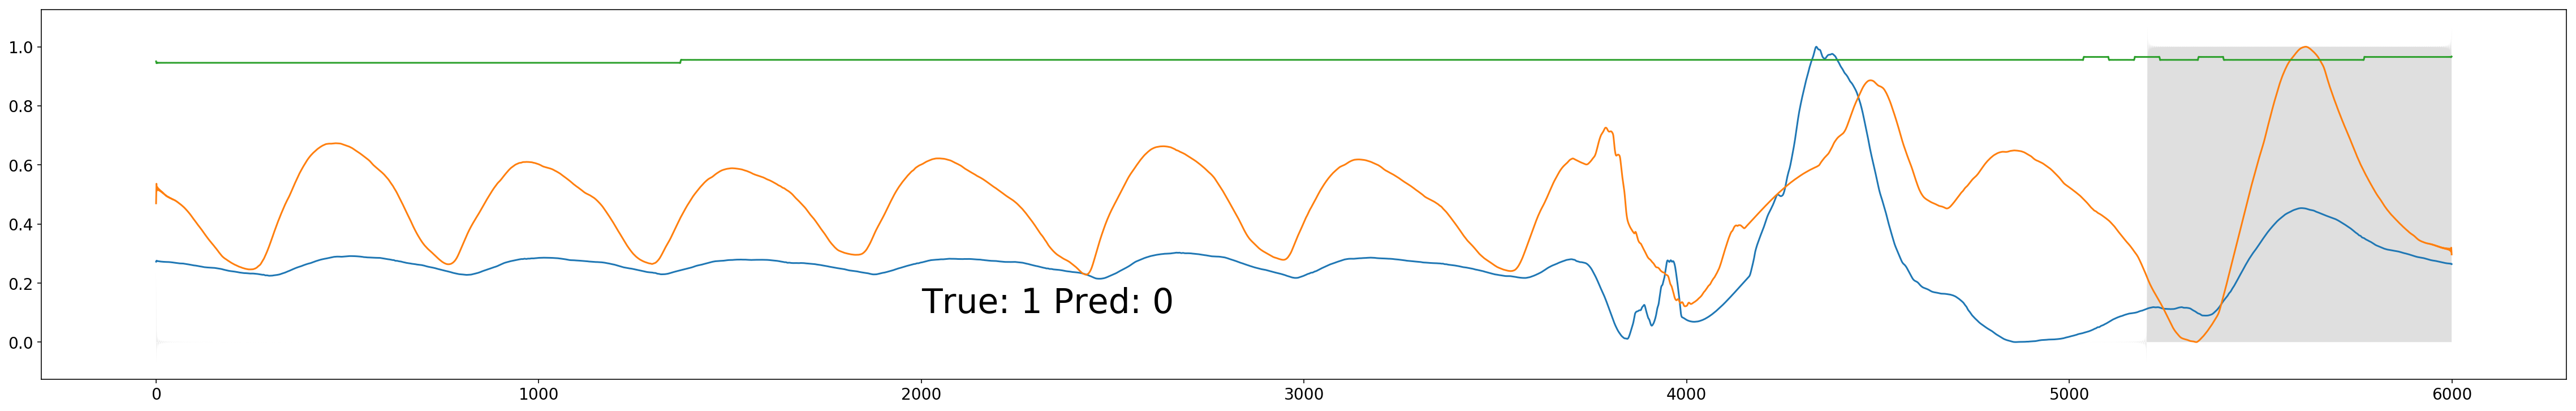

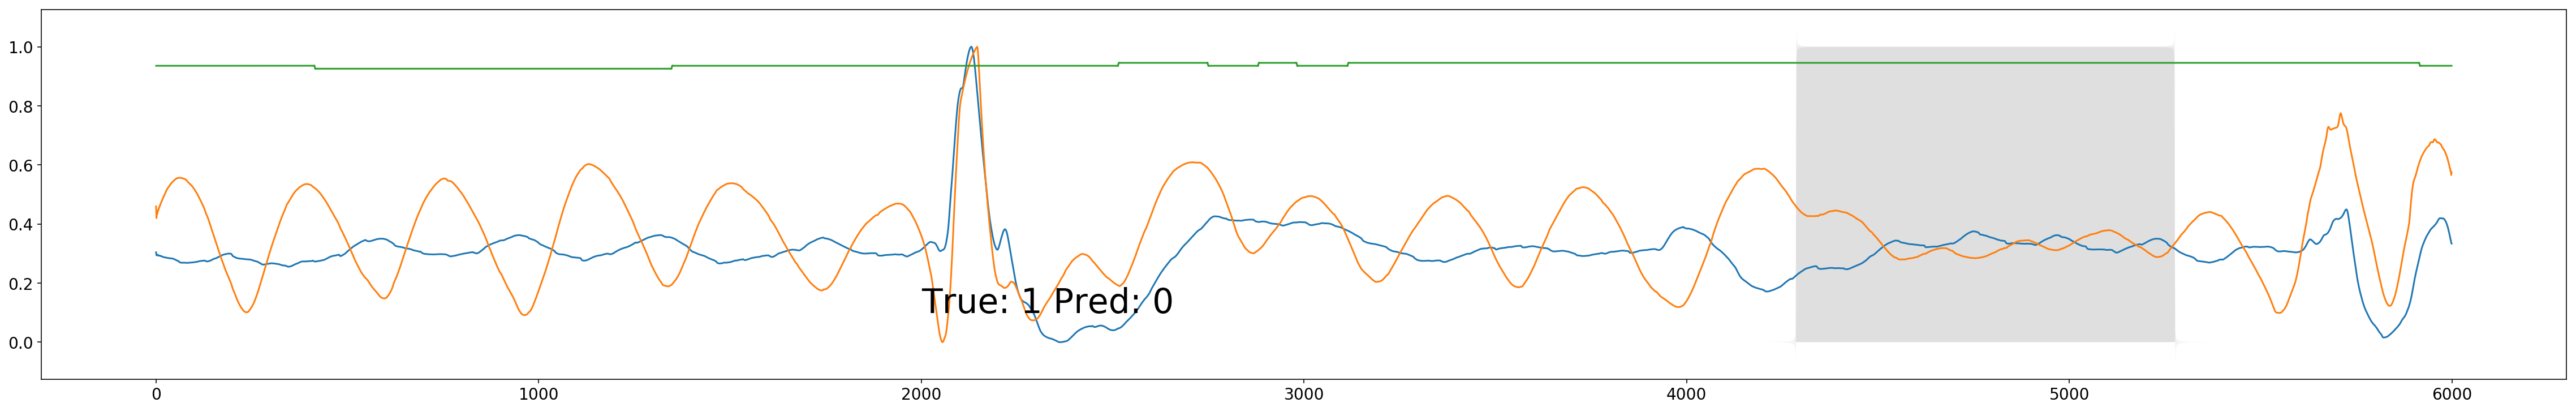

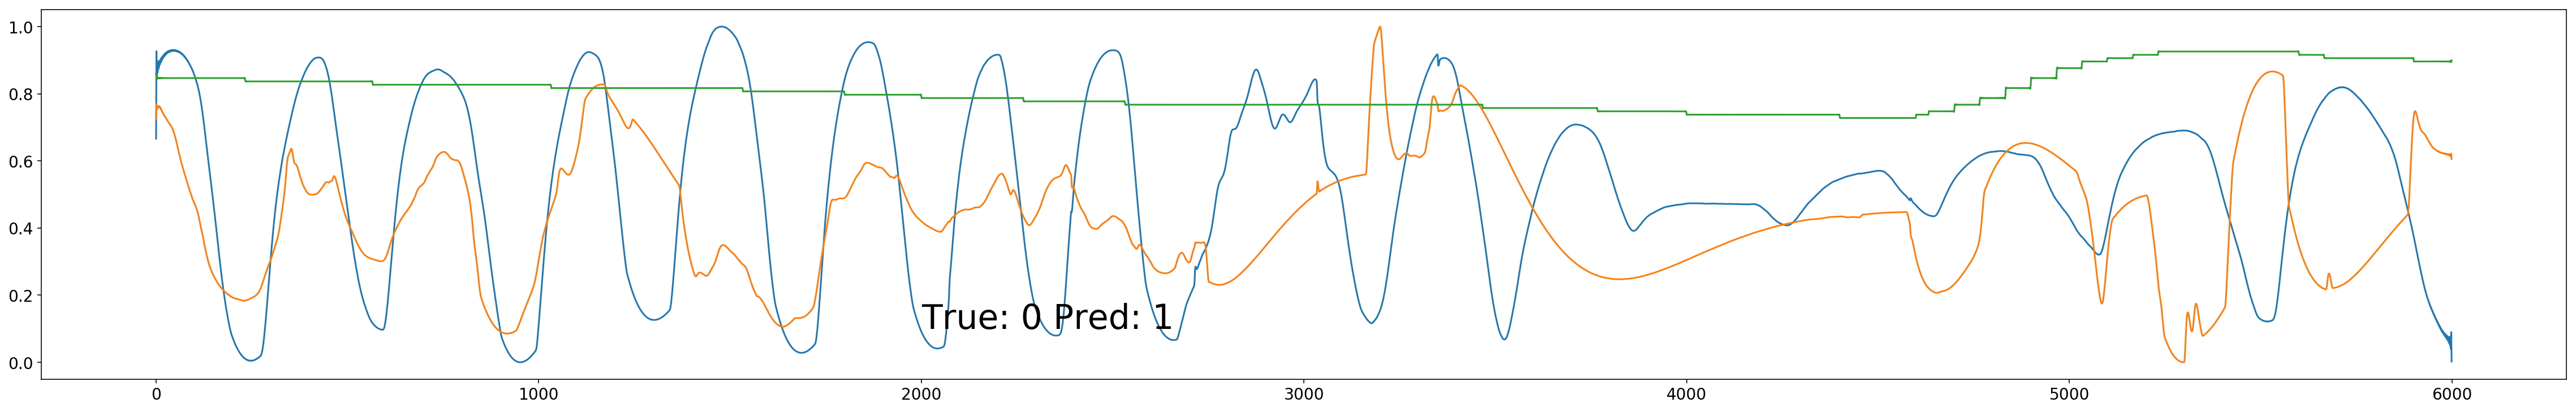

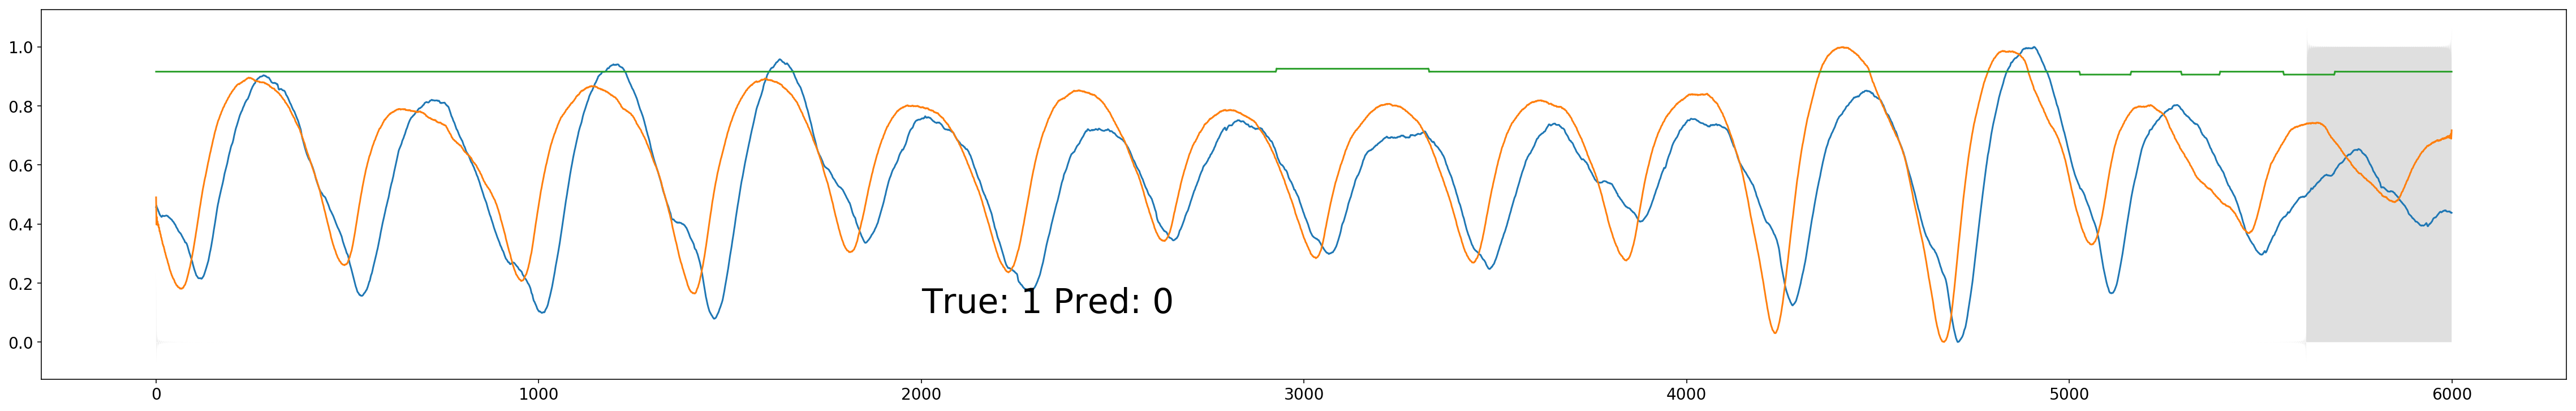

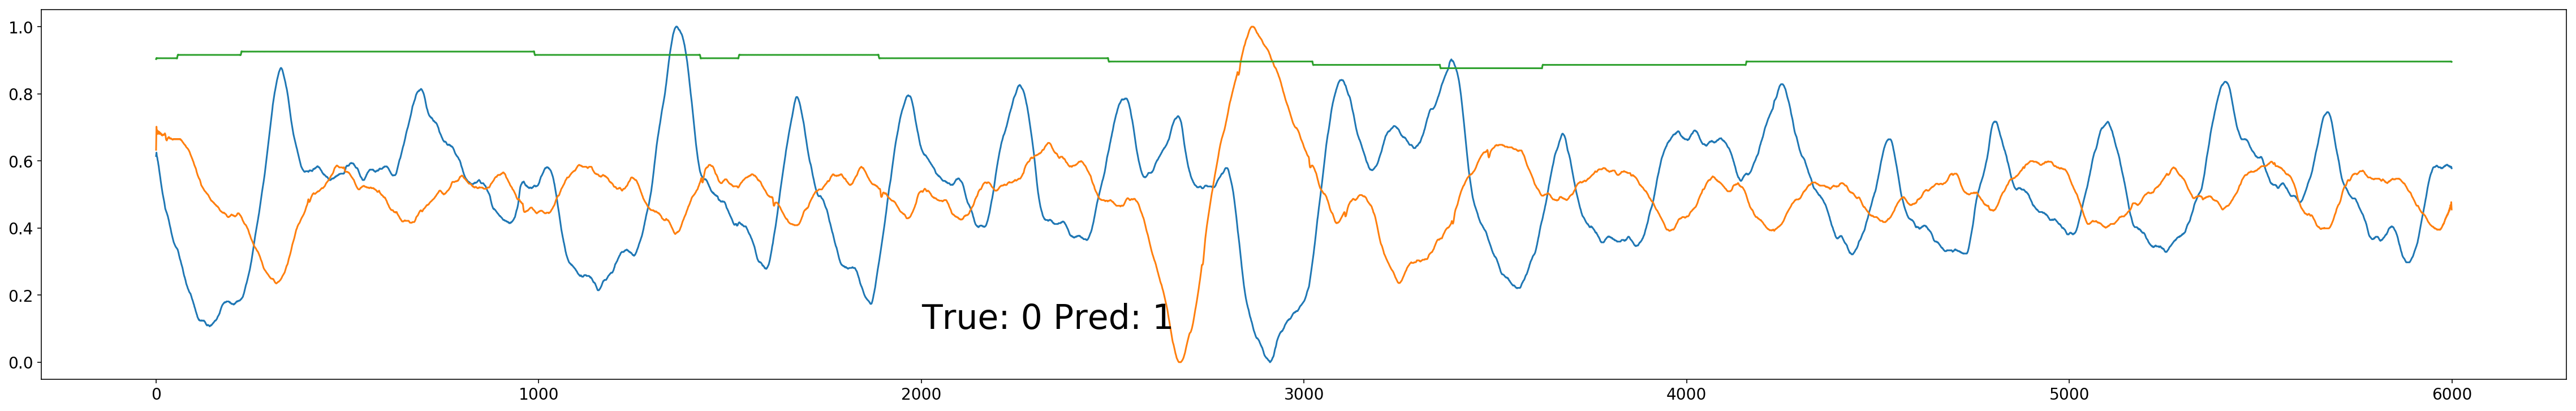

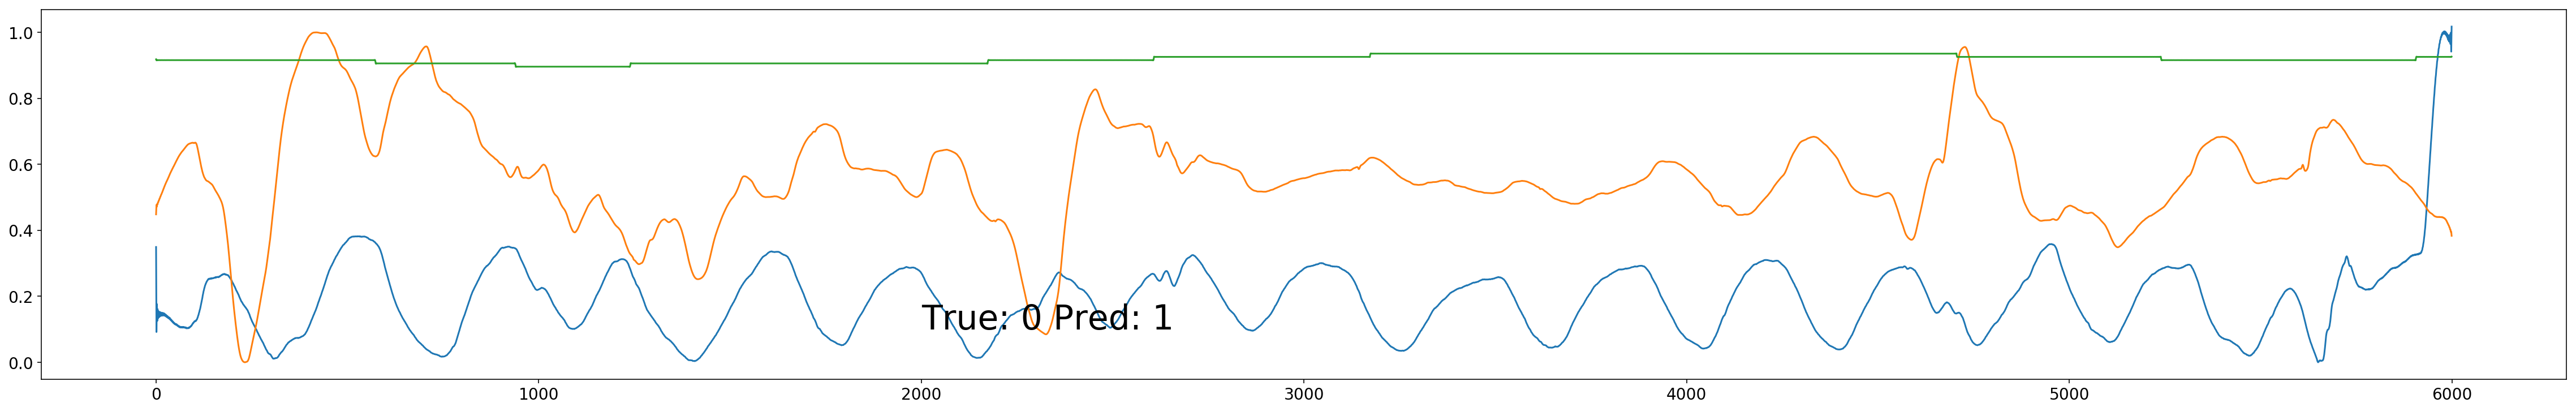

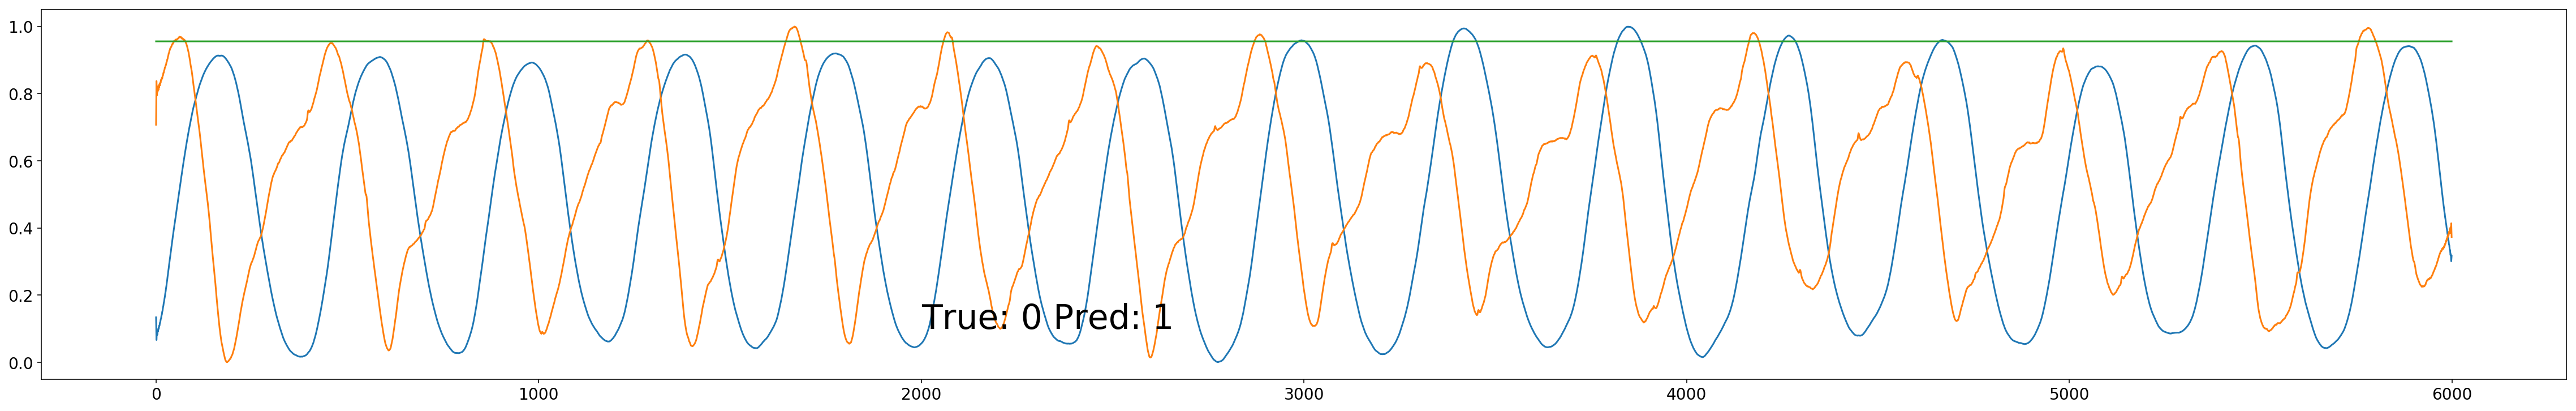

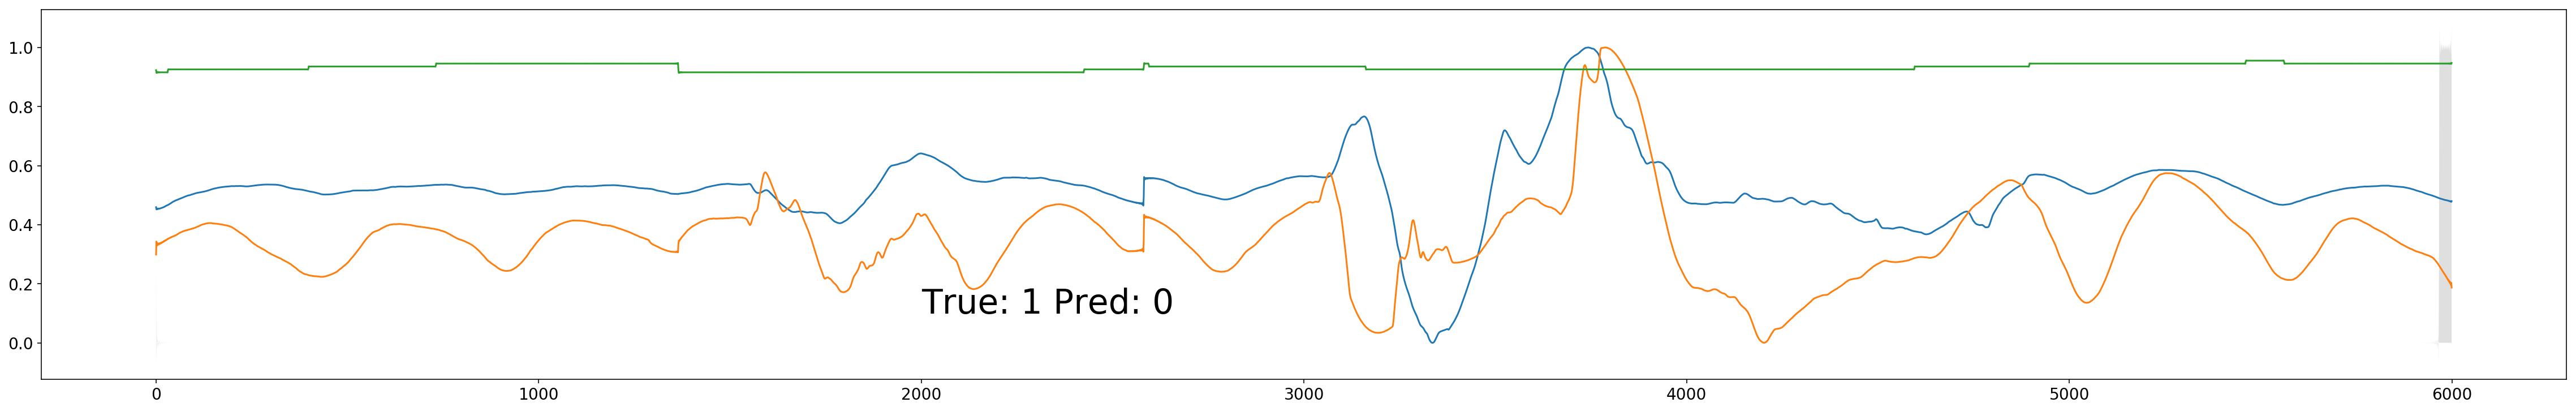

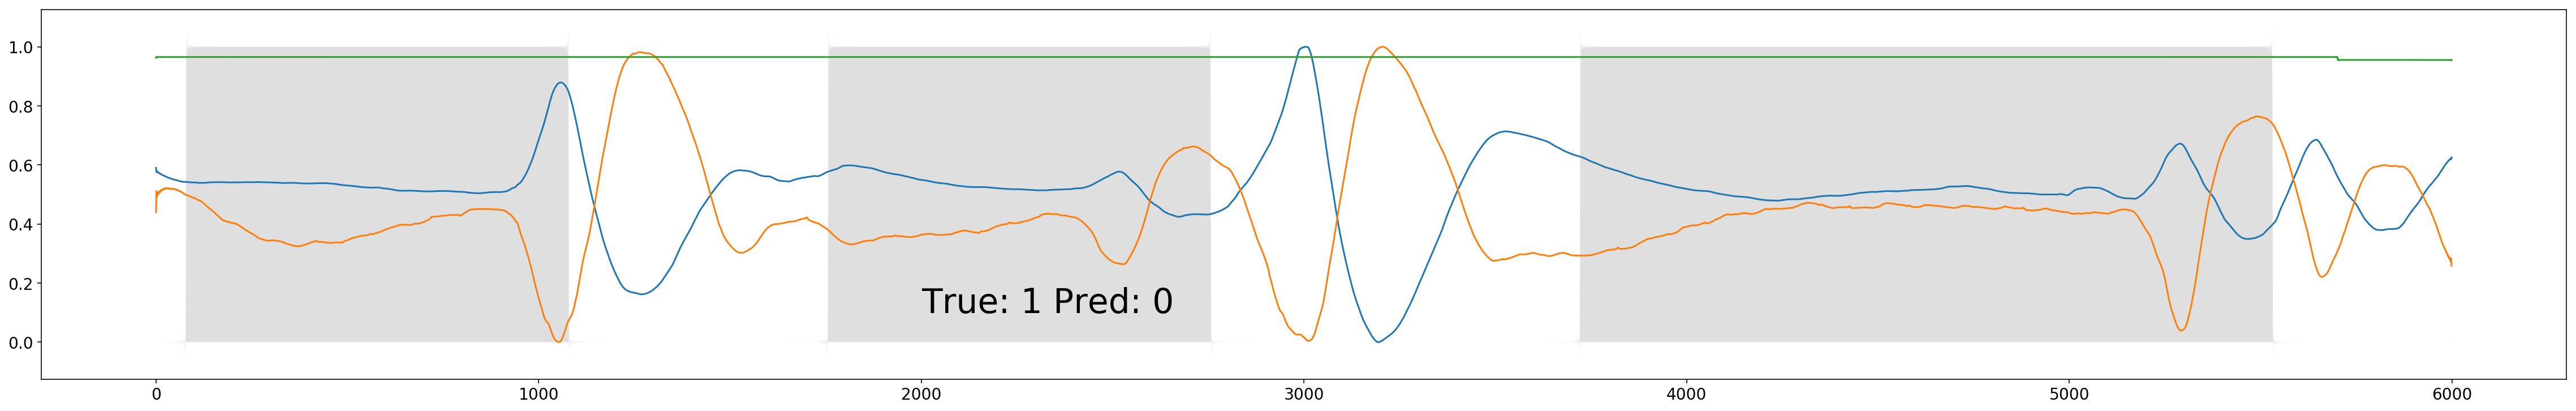

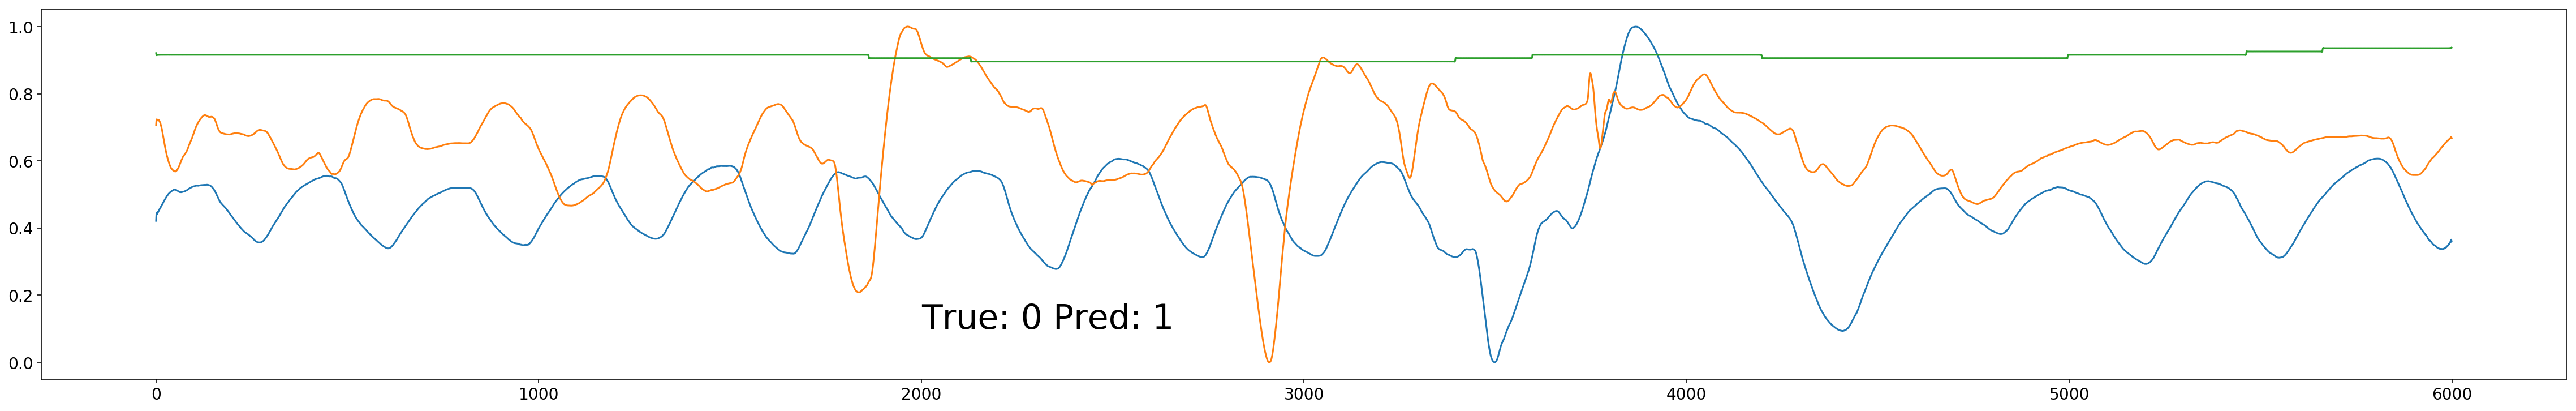

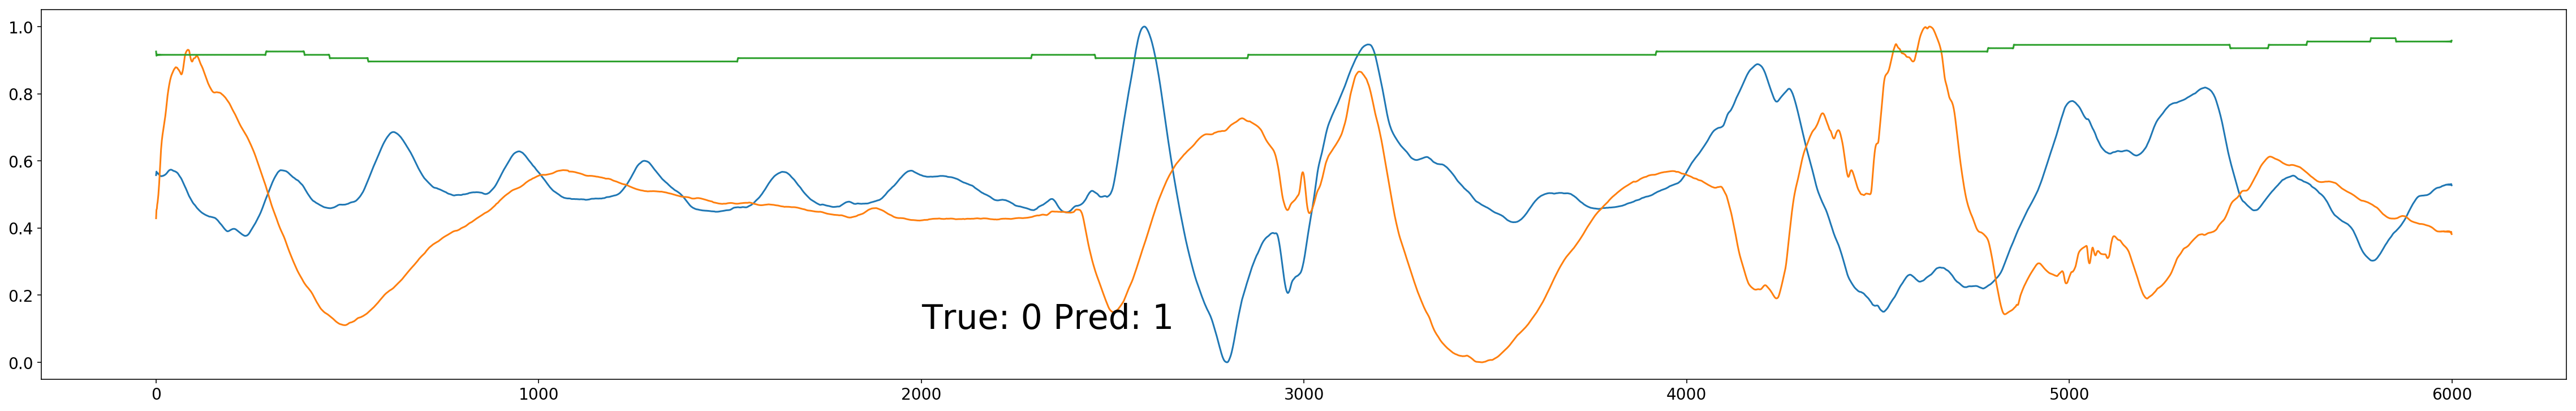

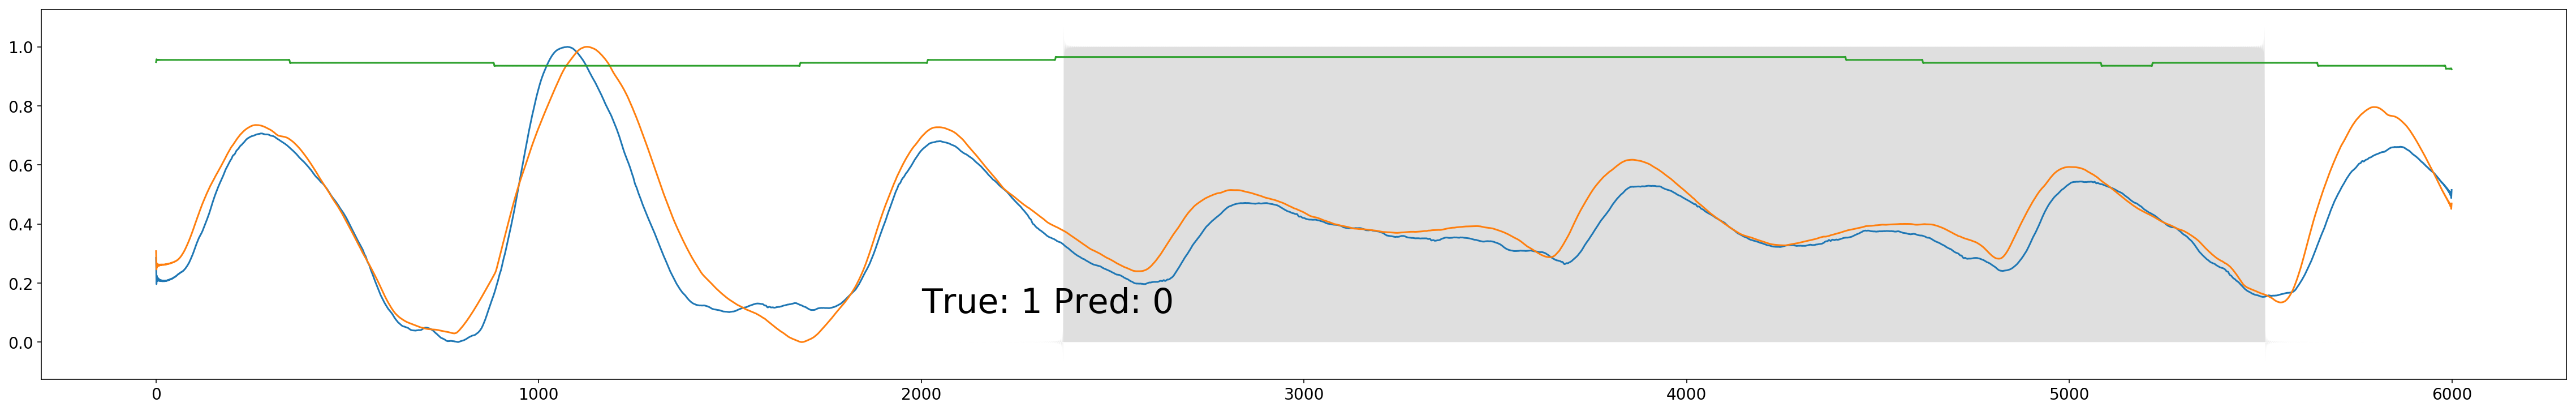

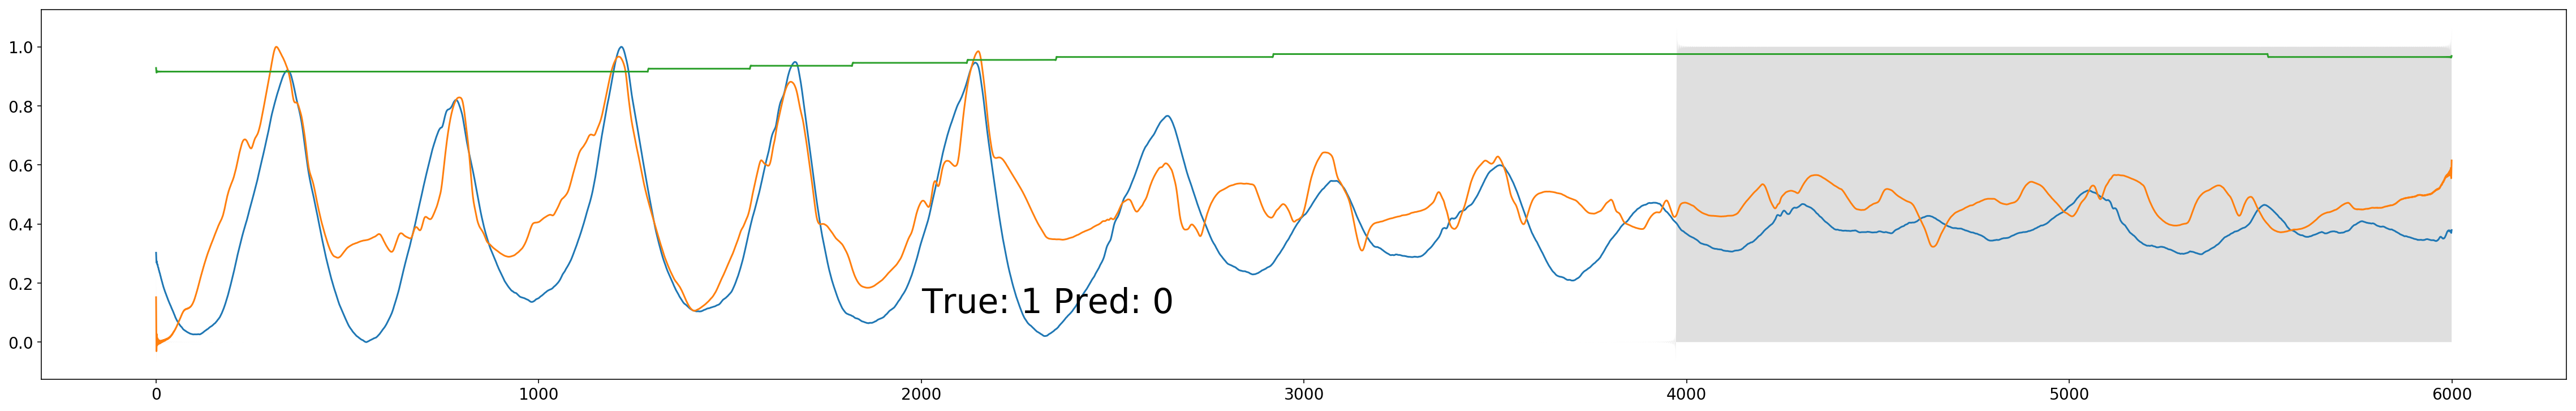

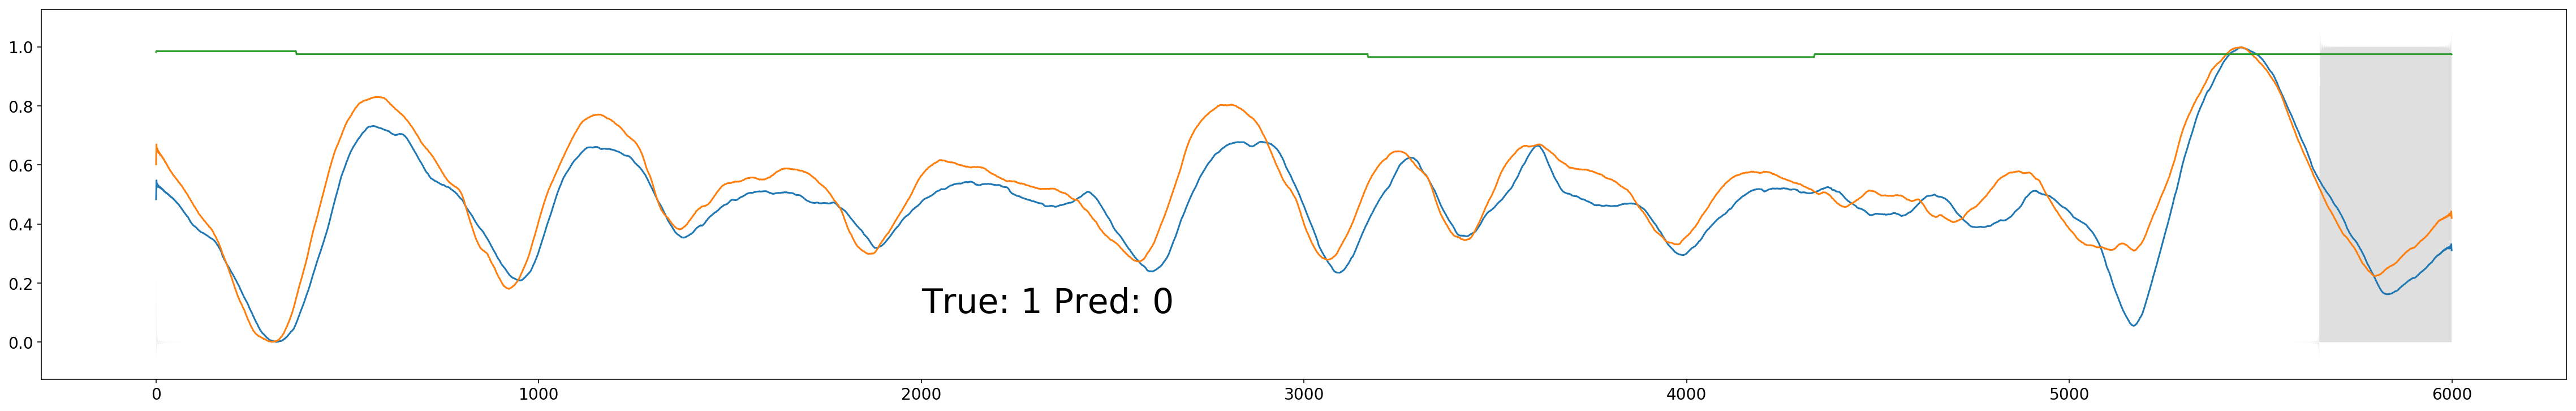

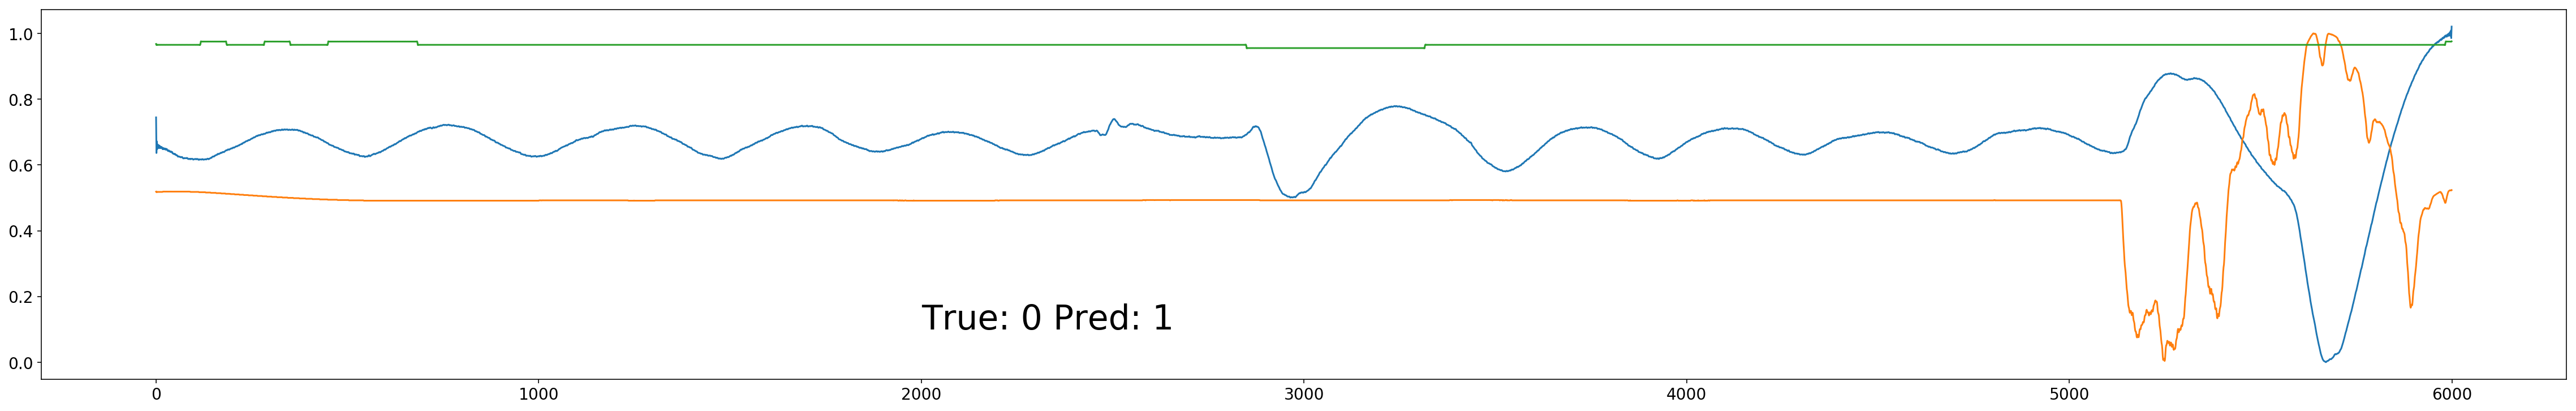

In [17]:
# Grey regions labels intervals of Apnea event
rcParams['figure.figsize'] = 40, 6
for _ in range(20):
    i = np.random.randint(0,len(indices))
    plt.figure()
    plt.plot(X[indices[i]]);
    plt.fill_between(range(0,6000), Y2[indices[i],:,0], facecolor='grey', alpha=0.25, interpolate=True);
    plt.text(2000,.1, str('True: {}'.format(int(Y[indices[i]]))+ ' Pred: {}'.format(int(ypred[indices[i]]))), fontsize=30);

In [18]:
# Build a text report showing the main classification metrics
print(classification_report(Y, ypred))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      6179
         1.0       0.75      0.75      0.75      1533

   micro avg       0.90      0.90      0.90      7712
   macro avg       0.84      0.85      0.84      7712
weighted avg       0.90      0.90      0.90      7712



>In the next [notebook](3_Transfer.ipynb), we will use trained model to predict apnea events from [Apnea-ECG dataset](https://physionet.org/physiobank/database/apnea-ecg/). This way we willl apply trianed model on a dataset that was obtained with different equipment.